# Gaussian mixture model estimation with the EM algorithm

<img src="adventures_bayes.gif" width="500" align="center">

Image credit:  [Bayesian Learning for Signal Processing](https://members.loria.fr/ADeleforge/files/bayesian_inference_electronic.pdf), Antoine Deleforge, LVA/ICA 2015 Summer School.

In [28]:
import numpy as np
import scipy as sp
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt

from gmm_tools import plot_GMM, plot_data, generate_Bayes_adventures_data

np.random.seed(0)

On Tuesday October 7, 1949, Thomas Bayes is going to visit Oxford University. Upon arriving at the university, three prankster students throw dozens of small stones at him from the roof. Bayes wants to know which student has thrown which stone. Determined, he begins to note the 2D position of each single stone on the ground.

(500, 2)


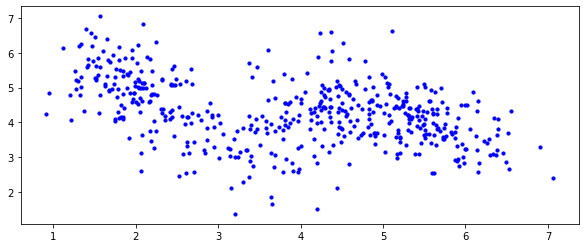

In [29]:
N = 500 # number of samples (number of stones)
D = 2 # number of dimensions (x and y coordinates)

gen = generate_Bayes_adventures_data(N, D)
x = gen[-1]

plot_data(x)
print(x.shape)

# Theoretical work

## Generative model

<img src="bayes_latents_1.png" width="400" align="center">

For his investigation, Thomas Bayes defines the generative process of the observed data as follows:

He observes a realization of a set of **observed random variables** denoted by $ \mathbf{x} = \{\mathbf{x}_n \in \mathbb{R}^2\}_{n=1}^N$, where $\mathbf{x}_n$ corresponds to the 2D position of the $n$-th stone.

These observations are generated from a set of **latent unobserved random variables** denoted by $ \mathbf{z} = \{z_n \in \{1,...,K\} \}_{n=1}^N$, where $z_n$ denotes the identity of the student (among $K=3$ students) who threw the $n$-th stone.

The relationships between the latent and observed variables are defined by their **joint distribution**, also called **complete-data likelihood**:


$$ 
\begin{aligned}
p(\mathbf{x}, \mathbf{z}; \theta) &= \prod_{n=1}^N p(\mathbf{x}_n | {z}_n; \theta) p({z}_n; \theta)  \\
&= \prod_{n=1}^N \prod_{k=1}^K \left( p(\mathbf{x}_n | {z}_n=k; \theta) p({z}_n=k; \theta) \right)^{\mathbb{1}\{z_n = k\}},
\end{aligned}
$$

where $\mathbb{1}\{z_n = k\} = \begin{cases}1 & \text{if } z_n = k \\ 0 & \text{otherwise}\end{cases}$.


The **prior** over the latent variables follows a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution):
$$ p({z}_n=k; \theta) = \pi_k, \qquad k \in \{1,...,K\}, \qquad \text{with }\, \pi_k > 0\, \text{ and }\, \sum_{k=1}^K = 1. $$

The **likelihood** is [Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$ p(\mathbf{x}_n | z_n=k; \theta) = \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k),$$

with $\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \displaystyle \frac{1}{\sqrt{\det(2\pi \boldsymbol\Sigma)}} \exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right).$

The set of **unknown deterministic model parameters** is defined by:

$$ \theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^K. $$

The **complete-data log-likelihood** is therefore given by:
$$ \ln p(\mathbf{x}, \mathbf{z}; \theta) =  \sum_{n=1}^N \sum_{k=1}^K \mathbb{1}\{z_n = k\} \left(\ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right). $$

## Posterior inference

### Exercise 1

#### Question 1.1 

Give the expression of the responsabilities $ r_{n,k} \triangleq p(z_n = k | \mathbf{x}_n; \theta)$.

#### Question 1.2 

How can you interpret the responsabilities?

#### Question 1.3 

In order to compute the responsabilities, it is necessary to estimate the unknown model parameters $\theta$. To do so, we would like to maximize the log-marginal likelihood $\ln p(\mathbf{x}; \theta) $. Give its expression and explain why it cannot be directly optimized.

## Expectation-Maximization algorithm

As direct maximum log-marginal likelihood estimation is intractable, we will derive an expectation-maximization (EM) algorithm.

### Exercise 2

#### Question 2.1 

Let $\tilde{\theta}$ denote the current estimate of the model parameters. Using the above definition of the complete-data log-likelihood, solve the E-step, that is compute the so-called $Q$-function, defined by: 

$$\begin{aligned}
Q(\theta, \tilde{\theta}) &= \mathbb{E}_{p(\mathbf{z} | \mathbf{x}; \tilde{\theta})}[\ln p(\mathbf{x}, \mathbf{z}; \theta)] \end{aligned}$$

Make the depency on the model parameters $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^K$ explicit (any constant with respect to these parameters can be omitted).

**Hints:**
- The expectation of a sum is the sum of the expectations.
- $\mathbb{E}_{p(\mathbf{z} | \mathbf{x}; \tilde{\theta})}[f(\mathbf{z}_n)] = \mathbb{E}_{p(\mathbf{z}_n | \mathbf{x}_n; \tilde{\theta})}[f(\mathbf{z}_n)]$ for any arbitrary function $f$;
- $\mathbb{E}_{p(\mathbf{z}_n | \mathbf{x}_n; \tilde{\theta})}[\mathbb{1}\{z_n = k\}] = \sum\limits_{z_n = 1}^K \mathbb{1}\{z_n = k\} p(\mathbf{z}_n | \mathbf{x}_n; \tilde{\theta}) = p(\mathbf{z}_n = k | \mathbf{x}_n; \tilde{\theta}) = r_{n,k} $.

#### Question 2.2 

You now have to solve the M-step, that is updating the model parameters by maximizing $Q(\theta, \tilde{\theta})$ with respect to (w.r.t) $\theta$. To do so, you will simply cancel the partial derivatives of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\mu}_k$, $\boldsymbol{\Sigma}_k$ and $\pi_k$.

Useful matrix derivation formulas can be found in the appendix at the end of this notebook, or in the [Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).


#### Question 2.2a 

Compute the partial derivative of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\mu}_k$ and set it to zero to get the update of $\boldsymbol{\mu}_k$.

$$\begin{aligned}
\nabla_{\boldsymbol{\mu}_k} Q(\theta, \tilde{\theta}) &=  \\
\end{aligned}$$

You will express the update as a function of $N_k = \sum_{n=1}^N r_{n,k}$. If we interpret $r_{n,k}$ as being equal to 1 if $\mathbf{x}_n$ belongs to component $k$ and 0 otherwise, $N_k$ corresponds to the number of points assigned to cluster $k$.

**Hint**: $\boldsymbol{\Sigma}_k$ is a covariance matrix so it is symetric.

#### Question 2.2b

Compute the partial derivative of $Q(\theta, \tilde{\theta})$ w.r.t $\boldsymbol{\Sigma}_k$ and set it to zero to get the update of $\boldsymbol{\Sigma}_k$.

$$\begin{aligned}
\nabla_{\boldsymbol{\Sigma}_k} Q(\theta, \tilde{\theta}) &=  \\
\end{aligned}$$

You will express the update as a function of $N_k = \sum_{n=1}^N r_{n,k}$.

**Hint**: Use the [trace trick](https://math.stackexchange.com/questions/1761198/proof-on-trace-trick): $\mathbf{x}^\top\boldsymbol{\Sigma}^{-1}\mathbf{x} = tr(\mathbf{x}^\top\boldsymbol{\Sigma}^{-1}\mathbf{x}) = tr(\boldsymbol{\Sigma}^{-1}\mathbf{x}\mathbf{x}^\top) $ and then refer to the matrix derivation formulas in the appendix.

#### Question 2.2c

The update for $\pi_k$ is obtained by maximizing $Q(\theta, \tilde{\theta})$ under the constraint that $\sum_{k=1}^K \pi_k = 1$. We obtain:

$$ \pi_k = N_k / N, $$

where $N_k = \sum_{n=1}^N r_{n,k}$. The optimal prior probablity $p(z_n = k) = \pi_k$ is thus given by the number of points $N_k$ in cluster $k$ divided by the total number of points $N$.

To obtain this expression you have to use the method of [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier): 

- you first cancel the partial derivative of the following Lagrangian w.r.t $\pi_k$:

    $$ \mathcal{L}(\theta, \tilde{\theta}, \lambda) = Q(\theta, \tilde{\theta}) + \lambda \left(\sum_{k=1}^K \pi_k - 1\right). $$

- then you simply inject this solution into the constraint to find out the solution for $\lambda$.

# Practical work

In [ ]:
class GMM():
    """
    Gaussian mixture model
    """

    def __init__(self, n_comp, data_dim=2, seed=None):

        super(GMM, self).__init__()

        self.n_comp = n_comp
        self.data_dim = 2
        self.init_param(seed=seed)
                
    def init_param(self, pis=None, means=None, covars=None, seed=None):
        """
        Initialize the model parameters using the provided arguments 
        or randomly.
        
        Inputs 
            pis: list of prior probabilities, length equal to self.n_comp
            means: list of GMM means, length equal to self.n_comp
            covars: list of GMM means, length equal to self.n_comp
        Outputs
            None
        """
        
        if seed is not None:
            np.random.seed(seed)
        
        if pis is not None:
            self.pis = pis
        else:
            self.pis = []
            for k in np.arange(self.n_comp):
                # prior set to 1/K
                self.pis.append(1/self.n_comp)
        
        if means is not None:
            self.means = means
        else:
            self.means = []
            for k in np.arange(self.n_comp):
                # mean vector drawn from a centered unit Gaussian
                mean = np.random.randn(self.data_dim)
                self.means.append(mean)
                
        if covars is not None:
            self.covars = covars
        else:
            self.covars = []
            for k in np.arange(self.n_comp):
                # identity covariance
                covar = np.eye(self.data_dim)
                self.covars.append(covar)
                
        if seed is not None:
            np.random.seed()
                
    def fit(self, data, n_iter=50):
        """
        Fit a GMM with the EM algorithm
        
        Inputs 
            data (number of points, dimension) array
            n_iter 
               
        Outputs
            log-marginal likelihood
        """
        LML = []
              
        for iter in np.arange(n_iter):
            
            resp = self.E_step(data)
            self.M_step(data, resp)
            LML.append(self.compute_LML(data))
            
        return LML
    
    def E_step(self, data):
        """
        Compute the responsabilities
        
        Inputs 
            data (number of points, dimension) array
               
        Outputs
            responsabilities (number of points, number of GMM components)
        """
        
        N = data.shape[0]
        
        resp = np.zeros((N,self.n_comp))
        
        ###### TO COMPLETE ######
        # Use the static method GMM.compute_pdf_multi_gaussian() defined below
        
        #########################
        
        return resp

    def M_step(self, data, resp):
        """
        Update the model parameters
        
        Inputs 
            data: (number of points, dimension) array
               
        Outputs
            None
        """
        
        ###### TO COMPLETE ######
        pass
        #########################
            
    def compute_LML(self, data):
        """
        Compute the log-marginal likelihood
        
        Inputs 
            data: (number of points, dimension) array
               
        Outputs
            log-marginal likelihood
        """
        
        LML = 0
        
        ###### TO COMPLETE ######              
        
        #########################
        
        return LML
        
    
    @staticmethod
    def compute_pdf_multi_gaussian(data, mean, covar):
        """
        Compute the pdf of a multivariate Gaussian distribution
                
        Inputs 
            data: data points to evaluate the pdf (number of points, dimension) array
            mean: mean vector (dimension,) array
            covar: covariance matrix (dimension, dimension) array
               
        Outputs
            pdf evaluated on 'data', (number of points,) array
        """
        rv = multivariate_normal(mean, covar)
        return rv.pdf(data)



The ```GMM``` class defined in the previous cell implements a Gaussian mixture model. It has two important methods:
- ```init_param()``` initializes the model parameters
- ```fit()``` runs the EM algorithm to estimate the model parameters. It alternates between the E- and M-steps, and after each iteration it computes the log-marginal likelihood.

In the following cell, we instantiate this class for our problem.

In [ ]:
gmm = GMM(n_comp=3, data_dim=2, seed=2)

### Exercise 3

#### Exercise 3.1

Complete the method that computes the log-marginal likelihood (LML) and run the following cell.

The LML is defined as a sum over the data points. You will divide this sum by the number of data points, so that the value of the objective function does not depend on the size of the dataset. In other words, compute the mean instead of the sum.

In [ ]:
LML_init = gmm.compute_LML(x)

print("log-marginal likelihood: %.4f" % LML_init)

if int(LML_init*1000) == -22548:
    print("so far, it seems to be ok")
else:
    print("argh, this is not the expected result, either you made a mistake, or my unit test is badly designed")

#### Exercise 3.2

Complete the method that computes the E-step and run the following cell.

In [ ]:
resp = gmm.E_step(x)
if np.sum(resp) == N:
    print("so far, it seems to be ok")
else:
    print("argh, this is not the expected result, either you made a mistake, or my unit test is badly designed")

To assign each point to each cluster, we simply look at the argmax of the reponsabilities. Run the following cell.

In [ ]:
z_hat = np.argmax(resp, axis=1)

fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(111)
plot_GMM(x, z_hat, gmm.means, gmm.covars, colors=['b','g','r'], ax=ax1)
ax1.set_title('estimation')

Can you explain what you observe?

#### Exercise 3.3

Complete the method that computes the M-step and run the following cell.

Hint: Updating the covariance matrix requires computing the outer product of vectors. Look at the notebook `numpy new axis trick` to help you.

In [ ]:
gmm.M_step(x, resp)

In [ ]:
LML = gmm.compute_LML(x)
delta_LML = LML - LML_init
print("log-marginal likelihood: %.4f" % LML)
print("log-marginal likelihood improvement: %.4f" % delta_LML)

if int(delta_LML*1000) == 19556:
    print("\nthe log-marginal likelihood increased, well done!")
else:
    print("argh, this is not the expected result, either you made a mistake, or my unit test is badly designed")

#### If you got all my encouraging messages, then you are ready to fit the GMM on the data!

In [ ]:
LML = gmm.fit(data=x, n_iter=50)

In the following cell, we plot the log-marginal likelihood along the iterations. It should be monotonically increasing, a nice feature of the EM algorithm which is very useful for debugging: if the log-marginal likelihood decreases, there is a bug.

In [ ]:
plt.plot(LML)
plt.title("log-marginal likelihood")
plt.xlabel("EM iterations")

Let's have a look to the results.

In [ ]:
resp = gmm.E_step(x)
z_hat = np.argmax(resp, axis=1)

fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(111)
plot_GMM(x, z_hat, gmm.means, gmm.covars, colors=['b','g','r'], ax=ax1)
ax1.set_title('estimation')

We used synthetic data, so we actually also know the true model parameters.

In [ ]:
(pis_true, means_true, covars_true, z_true, _) = gen


fig2 = plt.figure(figsize=(10,4))
ax2 = fig2.add_subplot(111)
plot_GMM(x, z_true, means_true, covars_true, colors=['b','g','r'], ax=ax2)
ax2.set_title('ground truth')

This is not perfect, but not that bad either... 

#### Exercise 3.4

Re-run the complete pipeline several times after changing the seed that is used to instantiate the GMM. Explain what you observe.


## Bonus

Use the [K-means](https://en.wikipedia.org/wiki/K-means_clustering) algorithm to initialize the model parameters.

## Appendix



For $f:  \mathbb{R}^{I \times J} \mapsto \mathbb{R}$, the gradient is defined by $\frac{d}{d \mathbf{X}} f(\mathbf{X}) = \nabla_{\mathbf{X}}f(\mathbf{X}) =  [\frac{\partial}{\partial X_{ij}} f(\mathbf{X}) ]_{ij} $.

Below are some useful derivatives:

\begin{equation}
\frac{\partial \mathbf{x}^T \mathbf{a}}{\partial \mathbf{x}} = \frac{\partial \mathbf{a}^T \mathbf{x}}{\partial \mathbf{x}} = \mathbf{a}
\end{equation}

\begin{equation}
\frac{\partial \mathbf{x}^T \mathbf{A} \mathbf{x}}{\partial \mathbf{x}} = 2 \mathbf{A} \mathbf{x}, \qquad \text{if } \mathbf{A} \text{ is symmetric}
\end{equation}

\begin{equation}
\frac{\partial}{\partial \mathbf{X}}tr(\mathbf{A}\mathbf{X}^T) = \mathbf{A}
\label{derTrace1}
\end{equation}

\begin{equation}
\frac{\partial}{\partial \mathbf{X}}tr(\mathbf{A}\mathbf{X}) = \mathbf{A}^T
\label{derTrace2}
\end{equation}

\begin{equation}
\frac{\partial}{\partial \mathbf{X}}tr(\mathbf{X}^{-1}\mathbf{A}) = -(\mathbf{X}^{-1}\mathbf{A}\mathbf{X}^{-1})^T
\label{derTraceInverse}
\end{equation}

\begin{equation}
\frac{\partial}{\partial \mathbf{X}}\ln \det(\mathbf{X}) = \big((\mathbf{X}^T)^{-1}\big)^T
\end{equation}